# Data analysis and Matplotlib Visualization


### Purpose: 
The purpose of this notebook is to extract the informatin for year 2009 from csv file which contain Medicare Outpatient claims data extracted from synpuf data source (https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/DE_Syn_PUF) using pandas or numpy libaries.and visualize the data using Matplotlib

### Input: 
A csv file which contains medicare claims data.

### Output:
1. A bar graph for total costs of outpatient care in each year.
2. A line graph comparing number of unique physicians visited per patient and total costs of outpatient care per patient

### Steps:
  Fist import all the relavant libaries,read input csv file,check few rows of csv file, and data type for each variable
  
  If its necessary, convert relavant column varible to appropriate data type e.g datetime format,numeric format
  
  Extract the data for year 2009 for line graph and store it as dataframe
  
  Perform all the counting and calculation for above extracted dataframe only as mentioned in below steps
#### For Bar Graph:
   1. To sum total cost of claims, first slice the relavant data and then use groupby function to sum the value for each
      patient.
   2. Using .plot.bar function from matplotlib, graph the step 1 dataframe with x-axis as Claim year and y-axis as total           cost of outpatient care. Do the necessary format change to look bar graph aesthetically fine.
   
#### For Line Graph:
  
   1. To count unique physicians visited, define the function which will give unique provider count and then use groupby
      function to call the function and convert it into dataframe.
   2. To sum total cost of claims, first slice the relavant data and then use groupby function to sum the value for each
      patient and convert into dataframe.
   3. Merge the dataframe created in step 1 and step 2 on Patient ID/Beneficiary ID.
   4. To calculate average claim per unique physician visit, use groupby and mean function in merged dataframe.
   5. Using line graph function matplotlib, graph the step 4 dataframe with x-axis as Unique physician count and y-axis as        Average cost of outpatient care. Do the necessary format change to look line graph aesthetically fine.

## Import libraries and read csv

In [2]:
#Import relevant dependancies
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

#File to load
file_to_load ="synpuf_outpatient_claims.csv"

#Read medicare outpatient file and store into pandas dataframe
outpatient_df=pd.read_csv(file_to_load,parse_dates=True,dtype="unicode")


## Extracting the relavant information

We are going to convert relavant columns to appropriate data format and then extracting data for 2009 year for line graph.

In [3]:
#Convert the "CLM_FROM_DT" and "CLM_THRU_DT" into datetime format
outpatient_df["CLM_FROM_DT"] = pd.to_datetime(outpatient_df["CLM_FROM_DT"],format='%Y-%m-%d',utc=True)
outpatient_df["CLM_THRU_DT"] = pd.to_datetime(outpatient_df["CLM_THRU_DT"],format='%Y-%m-%d',utc=True)
outpatient_df["CLM_FROM_DT1"] = outpatient_df["CLM_FROM_DT"].dt.year
outpatient_df.reset_index()

#Below commented code in not working due to older pandas version here
#outpatient_df["CLM_FROM_DT1"]=outpatient_df["CLM_FROM_DT"].index.to_period("Y")

#Convert dataframe "object" type to numeric type
outpatient_df["CLM_PMT_AMT"]=pd.to_numeric(outpatient_df["CLM_PMT_AMT"])

#Extracting data for only year 2009 from "CLM_FROM_DT"
outpatient_2009=outpatient_df[(outpatient_df["CLM_FROM_DT"]>="2009-01-01")&(outpatient_df["CLM_FROM_DT"]<="2009-12-31")]


In [4]:
#Totalnumber of columns and row
outpatient_2009.shape

(322358, 78)

## Bar Graph: Total Costs of Outpatient Care

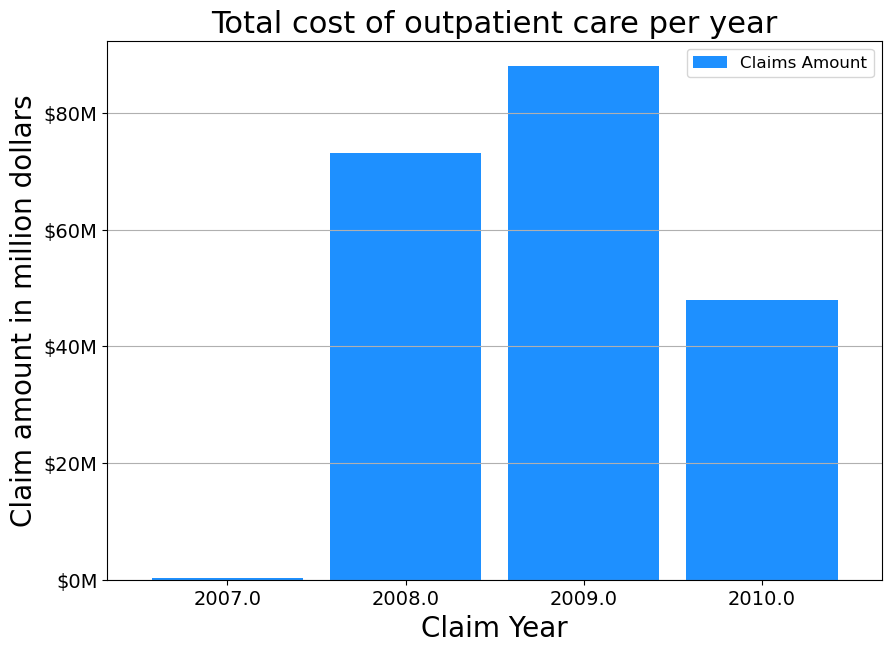

<Figure size 640x480 with 0 Axes>

In [5]:
#Grouping dataframe by year and sum the "CLM_PMT_AMT"
total_cost=outpatient_df.loc[:,["CLM_FROM_DT1","CLM_PMT_AMT"]]

#Grouping the dataframe by Beneficiary code,convert Claim date into year format and sum the "CLM_PMT_AMT" values
total_cost_df=total_cost.groupby("CLM_FROM_DT1")["CLM_PMT_AMT"].sum()

#Reseting the index and rename the columns
total_cost_df.reset_index()
total_cost_final=pd.DataFrame(total_cost_df)
total_cost_final=total_cost_final.rename(index=str,columns={"CLM_PMT_AMT":"Claims Amount"})
total_cost_final["Claims Amount"]=total_cost_final["Claims Amount"]/1000000

#Plot the total_cost_final dataframe to bar graph.
total_cost_bar=total_cost_final.plot(kind="bar",align="center",rot=0,
                                     figsize=(10,7),legend=True, fontsize=14,width=0.85,color="dodgerblue")

#Formatting x-axis labels
plt.xlabel("Claim Year",fontsize=20)

#Formatting y-axis labels
fmt = '${x:,.0f}M'
tick = mtick.StrMethodFormatter(fmt)
total_cost_bar.yaxis.set_major_formatter(tick)
plt.ylabel("Claim amount in million dollars",fontsize=20)
plt.grid(axis="y")
# Plot the graph title
plt.title("Total cost of outpatient care per year",fontsize=22)

#Plot the graph legend
plt.legend(fontsize=12,loc=1)

#Print the graph
plt.show()
plt.tight_layout()

## Line Graph: Number of unique physicians visit per patient and total cost of outpatient care

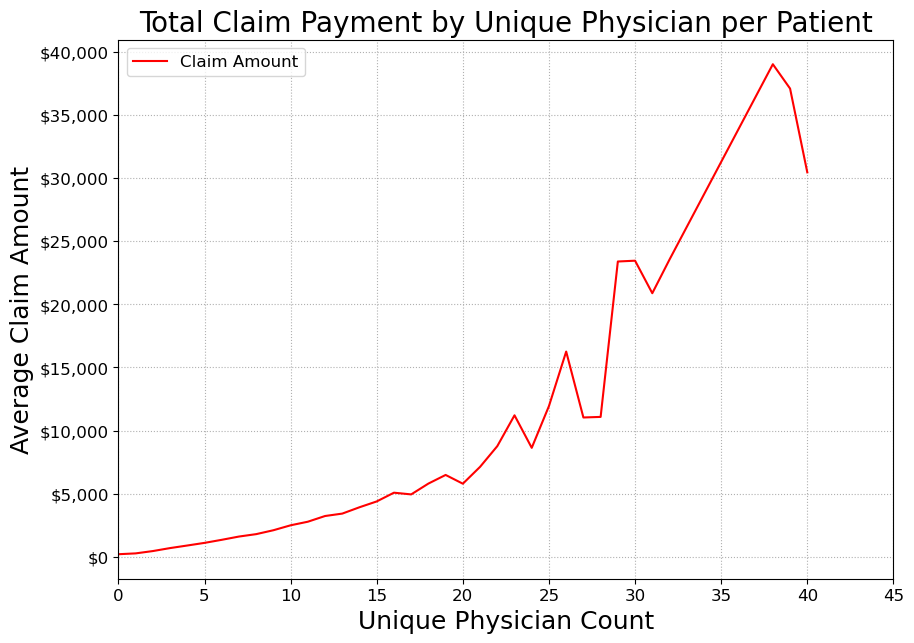

<Figure size 640x480 with 0 Axes>

In [6]:
#define the function to get unique value across three columns for each patient
def get_unique(group):
    physician_cols = [group['AT_PHYSN_NPI'], 
                      group['OP_PHYSN_NPI'], 
                      group['OT_PHYSN_NPI']]
    return len(pd.concat(physician_cols).dropna(inplace=False).unique())
#Call the function with grouping by beneficiery code
df_1=outpatient_2009.groupby("DESYNPUF_ID").apply(get_unique).reset_index()

#Slice the relavant data using column names
df_total_cost=outpatient_2009.loc[:, ["DESYNPUF_ID", "CLM_PMT_AMT"]]
#Grouping the dataframe by Beneficiary code,and sum the "CLM_PMT_AMT" values
df_2=df_total_cost.groupby("DESYNPUF_ID")["CLM_PMT_AMT"].sum()
df_2=df_2.reset_index()

#Merge two dataframes "df_1" and "df_2"
df_Pt_Phy=pd.merge(df_1,df_2,on=["DESYNPUF_ID"],how="inner")
df_Pt_Phy=df_Pt_Phy.rename(index=str, columns=({"DESYNPUF_ID ":"PatientID",
                                                0:"Unique_Physician","CLM_PMT_AMT":"Claim Amount"}))
#Grouping the merged dataframe 
pt_phy=df_Pt_Phy.groupby("Unique_Physician")["Claim Amount"].mean().reset_index()

#Plot the line graph
pt_phy_line=pt_phy.plot(kind="line",x="Unique_Physician",y="Claim Amount",
                                 figsize=(10,7),fontsize=12,legend=True,color="red")

#Formatting x-axis labels
plt.xlabel("Unique Physician Count",fontsize=18)
plt.xlim(0,45)

#Formatting y-axis labels
plt.ylabel("Average Claim Amount",fontsize=18)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
pt_phy_line.yaxis.set_major_formatter(tick)
plt.grid(linestyle="dotted")
# Plot the graph title
plt.title("Total Claim Payment by Unique Physician per Patient",fontsize=20)

#Plot the graph legend
plt.legend(fontsize=12,loc=2)

#Print the graph
plt.show()
plt.tight_layout()